<a href="https://colab.research.google.com/github/MJ-best/Challenge_to_the_Competition/blob/main/%5B%EC%97%98%EB%A6%AC%EC%8A%A4MINI%EA%B2%BD%EC%A7%84%EB%8C%80%ED%9A%8C_16%EB%93%B1%5Dtime_series_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 필수 라이브러리
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# 추가를 원하는 라이브러리가 있다면 자유롭게 설치 후 추가하세요.

In [ ]:
pd.set_option('display.max_columns', None)

## 학습용 데이터 불러오기

In [ ]:
# 전체 데이터셋
raw_df = pd.read_csv('/mnt/elice/dataset/continuous_factory_process.csv', index_col="time_stamp")

In [ ]:
raw_df.head(5)

,AmbientConditions.AmbientHumidity.U.Actual,AmbientConditions.AmbientTemperature.U.Actual,Machine1.RawMaterial.Property1,Machine1.RawMaterial.Property2,Machine1.RawMaterial.Property3,Machine1.RawMaterial.Property4,Machine1.RawMaterialFeederParameter.U.Actual,Machine1.Zone1Temperature.C.Actual,Machine1.Zone2Temperature.C.Actual,Machine1.MotorAmperage.U.Actual,Machine1.MotorRPM.C.Actual,Machine1.MaterialPressure.U.Actual,Machine1.MaterialTemperature.U.Actual,Machine1.ExitZoneTemperature.C.Actual,Machine2.RawMaterial.Property1,Machine2.RawMaterial.Property2,Machine2.RawMaterial.Property3,Machine2.RawMaterial.Property4,Machine2.RawMaterialFeederParameter.U.Actual,Machine2.Zone1Temperature.C.Actual,Machine2.Zone2Temperature.C.Actual,Machine2.MotorAmperage.U.Actual,Machine2.MotorRPM.C.Actual,Machine2.MaterialPressure.U.Actual,Machine2.MaterialTemperature.U.Actual,Machine2.ExitZoneTemperature.C.Actual,Machine3.RawMaterial.Property1,Machine3.RawMaterial.Property2,Machine3.RawMaterial.Property3,Machine3.RawMaterial.Property4,Machine3.RawMaterialFeederParameter.U.Actual,Machine3.Zone1Temperature.C.Actual,Machine3.Zone2Temperature.C.Actual,Machine3.MotorAmperage.U.Actual,Machine3.MotorRPM.C.Actual,Machine3.MaterialPressure.U.Actual,Machine3.MaterialTemperature.U.Actual,Machine3.ExitZoneTemperature.C.Actual,FirstStage.CombinerOperation.Temperature1.U.Actual,FirstStage.CombinerOperation.Temperature2.U.Actual,FirstStage.CombinerOperation.Temperature3.C.Actual,Stage1.Output.Measurement0.U.Actual,Stage1.Output.Measurement0.U.Setpoint,Stage1.Output.Measurement1.U.Actual,Stage1.Output.Measurement1.U.Setpoint,Stage1.Output.Measurement2.U.Actual,Stage1.Output.Measurement2.U.Setpoint,Stage1.Output.Measurement3.U.Actual,Stage1.Output.Measurement3.U.Setpoint,Stage1.Output.Measurement4.U.Actual,Stage1.Output.Measurement4.U.Setpoint,Stage1.Output.Measurement5.U.Actual,Stage1.Output.Measurement5.U.Setpoint,Stage1.Output.Measurement6.U.Actual,Stage1.Output.Measurement6.U.Setpoint,Stage1.Output.Measurement7.U.Actual,Stage1.Output.Measurement7.U.Setpoint,Stage1.Output.Measurement8.U.Actual,Stage1.Output.Measurement8.U.Setpoint,Stage1.Output.Measurement9.U.Actual,Stage1.Output.Measurement9.U.Setpoint,Stage1.Output.Measurement10.U.Actual,Stage1.Output.Measurement10.U.Setpoint,Stage1.Output.Measurement11.U.Actual,Stage1.Output.Measurement11.U.Setpoint,Stage1.Output.Measurement12.U.Actual,Stage1.Output.Measurement12.U.Setpoint,Stage1.Output.Measurement13.U.Actual,Stage1.Output.Measurement13.U.Setpoint,Stage1.Output.Measurement14.U.Actual,Stage1.Output.Measurement14.U.Setpoint,Machine4.Temperature1.C.Actual,Machine4.Temperature2.C.Actual,Machine4.Pressure.C.Actual,Machine4.Temperature3.C.Actual,Machine4.Temperature4.C.Actual,Machine4.Temperature5.C.Actual,Machine4.ExitTemperature.U.Actual,Machine5.Temperature1.C.Actual,Machine5.Temperature2.C.Actual,Machine5.Temperature3.C.Actual,Machine5.Temperature4.C.Actual,Machine5.Temperature5.C.Actual,Machine5.Temperature6.C.Actual,Machine5.ExitTemperature.U.Actual,Stage2.Output.Measurement0.U.Actual,Stage2.Output.Measurement0.U.Setpoint,Stage2.Output.Measurement1.U.Actual,Stage2.Output.Measurement1.U.Setpoint,Stage2.Output.Measurement2.U.Actual,Stage2.Output.Measurement2.U.Setpoint,Stage2.Output.Measurement3.U.Actual,Stage2.Output.Measurement3.U.Setpoint,Stage2.Output.Measurement4.U.Actual,Stage2.Output.Measurement4.U.Setpoint,Stage2.Output.Measurement5.U.Actual,Stage2.Output.Measurement5.U.Setpoint,Stage2.Output.Measurement6.U.Actual,Stage2.Output.Measurement6.U.Setpoint,Stage2.Output.Measurement7.U.Actual,Stage2.Output.Measurement7.U.Setpoint,Stage2.Output.Measurement8.U.Actual,Stage2.Output.Measurement8.U.Setpoint,Stage2.Output.Measurement9.U.Actual,Stage2.Output.Measurement9.U.Setpoint,Stage2.Output.Measurement10.U.Actual,Stage2.Output.Measurement10.U.Setpoint,Stage2.Output.Measurement11.U.Actual,Stage2.Output.Measurement11.U.Setpoint,Stage2.Output.Measurement12.U.Actual,Stage2.Output.Measurement12.U.Setpoint,Stage2

## 데이터 전처리
- setpoint라는 문자열이 들어간 열을 모두 제거
- time_stamp 시계열 Date로 바꿔서 저장
- 머신1, 머신2, 머신3, 컴바이너 데이터 ---> X1
- 스테이지1에서의 출력값 ---> y1
- 머신4, 머신5 데이터 ---> X2
- 스테이지2에서의 출력값 ---> y2

In [ ]:
def data_processing(df):
    
    #time_stamp를 타임스템프 데이터 형으로 변환해준다
    df.reset_index(drop=False, inplace=True)
    df['Date'] = pd.to_datetime(df['time_stamp'])
    df.drop('time_stamp', axis = 1, inplace=True)
    df.set_index('Date', inplace=True)
    
    del_col = []
    for str in df.columns:
        if str.find("Setpoint") != -1:
            del_col.append(str)
    df.drop(columns = del_col, inplace = True)
    
    stage1_col = []

    for str in df.columns:
        if str.find("Stage1") != -1:
            stage1_col.append(str)
    #stage1에서 예측값이 될 y1
    y1 = df[stage1_col]
    
    stage2_col = []

    for str in df.columns:
        if str.find("Stage2") != -1:
            stage2_col.append(str)
    #stage2에서 예측값이 될 y2
    y2 = df[stage2_col]
    
    data = df.drop(stage1_col+stage2_col,axis=1)
    
    machin4_col = []

    for str in data.columns:
        if str.find("Machine4") != -1:
            machin4_col.append(str)

    machin5_col = []

    for str in data.columns:
        if str.find("Machine5") != -1:
            machin5_col.append(str)

    X1 = data.drop(machin4_col+machin5_col, axis=1)       

    X2 = data[machin4_col+machin5_col]
    
    return X1, X2, y1, y2

In [ ]:
X1, X2, y1, y2 = data_processing(raw_df)

In [ ]:
X1_train = X1.iloc[:9016, :]
X1_test = X1.iloc[9016:, :]
X2_train = X2.iloc[:9016, :]
X2_test = X2.iloc[9016:, :]
y1_train = y1.iloc[:9016, :]
y1_test = y1.iloc[9016:, :]
y2_train = y2.iloc[:9016, :]
y2_test = y2.iloc[9016:, :]

## MinMaxScaler

In [ ]:
# MinMaxScaler적용을 위해 2차원으로 데이터를 변형 시켜준다
X1_train_ = X1_train.values.reshape(-1,len(X1_train.columns))
X2_train_ = X2_train.values.reshape(-1,len(X2_train.columns))
X1_test_ = X1_test.values.reshape(-1,len(X1_test.columns))
X2_test_ = X2_test.values.reshape(-1,len(X2_test.columns))

y1_train_ = y1_train.values.reshape(-1,len(y1_train.columns))
y2_train_ = y2_train.values.reshape(-1,len(y2_train.columns))
y1_test_ = y1_test.values.reshape(-1,len(y1_test.columns))
y2_test_ = y2_test.values.reshape(-1,len(y2_test.columns))

In [ ]:
#Scaler 정의
from sklearn.preprocessing import MinMaxScaler

X1scaler = MinMaxScaler()
X2scaler = MinMaxScaler()

y1scaler = MinMaxScaler()
y2scaler = MinMaxScaler()

In [ ]:
#데이터 정규화

X1scaler.fit(X1_train_)
X2scaler.fit(X2_train_)
y1scaler.fit(y1_train_)
y2scaler.fit(y2_train_)

X1_train_scaled = X1scaler.transform(X1_train_)
X2_train_scaled = X2scaler.transform(X2_train_)

y1_train_scaled = y1scaler.transform(y1_train_)
y2_train_scaled = y2scaler.transform(y2_train_)

X1_test_scaled = X1scaler.transform(X1_test_)
X2_test_scaled = X2scaler.transform(X2_test_)

y1_test_scaled = y1scaler.transform(y1_test_)
y2_test_scaled = y2scaler.transform(y2_test_)

In [ ]:
X1_train_scaled_df = pd.DataFrame(data = X1_train_scaled, columns = X1_train.columns)
X2_train_scaled_df = pd.DataFrame(data = X2_train_scaled, columns = X2_train.columns)
X1_test_scaled_df = pd.DataFrame(data = X1_test_scaled, columns = X1_test.columns)
X2_test_scaled_df = pd.DataFrame(data = X2_test_scaled, columns = X2_test.columns)

y1_train_scaled_df = pd.DataFrame(data = y1_train_scaled, columns = y1_train.columns)
y2_train_scaled_df = pd.DataFrame(data = y2_train_scaled, columns = y2_train.columns)
y1_test_scaled_df = pd.DataFrame(data = y1_test_scaled, columns = y1_test.columns)
y2_test_scaled_df = pd.DataFrame(data = y2_test_scaled, columns = y2_test.columns)

## 분산을 기준으로 분산이 낮은 특성(정보의 변화가 거의 없는 의미없는 특성)을 제거한다/
- 의미없는 데이터 컬럼을 제거
- 주어진 기준 값보다 높은 분산을 가진 특성을 선택합니다

In [ ]:
# X1에서 각 특성이 가지는 분산을 확인
from sklearn.feature_selection import VarianceThreshold

X1_th = VarianceThreshold()
X1_th.fit(X1_train_scaled_df).variances_

array([0.10212623, 0.07634414, 0.14850347, 0.09087394, 0.06949497,
       0.08965471, 0.01119462, 0.01310467, 0.08994234, 0.0181292 ,
       0.07639655, 0.02505957, 0.00948239, 0.00462042, 0.19860345,
       0.19860345, 0.19860345, 0.19860345, 0.0030264 , 0.00276209,
       0.00260405, 0.02000503, 0.04308107, 0.01123182, 0.01164637,
       0.04028651, 0.16542033, 0.21150074, 0.15931933, 0.18893357,
       0.00344834, 0.00369257, 0.01678782, 0.03937111, 0.04019865,
       0.05599431, 0.04861255, 0.02383631, 0.00477485, 0.08090691,
       0.02894687])

- X1에서의 분산을 확인해보면 0.08 이상의 분산을 가져야 의미가 있다고 볼 수 있다.

In [ ]:
# X2에서 각 특성이 가지는 분산을 확인
from sklearn.feature_selection import VarianceThreshold

X2_th = VarianceThreshold()
X2_th.fit(X2_train_scaled_df).variances_

array([0.00057879, 0.00072539, 0.00692063, 0.00407967, 0.00692063,
       0.00196862, 0.02109589, 0.0020704 , 0.00753475, 0.03373575,
       0.04407286, 0.00188314, 0.01509776, 0.01011232])

- X2에서의 분산을 살펴보면 0.007 이상의 분산을 가져야 의미가 있다고 볼 수 있다.

In [ ]:
from sklearn.feature_selection import VarianceThreshold

X1_thresholder = VarianceThreshold(threshold=0.08)
X1_thresholder.fit(X1_train_scaled)

X1_train_scaled = X1_thresholder.transform(X1_train_scaled)
X1_test_scaled = X1_thresholder.transform(X1_test_scaled)

In [ ]:
from sklearn.feature_selection import VarianceThreshold

X2_thresholder = VarianceThreshold(threshold=0.007)
X2_thresholder.fit(X2_train_scaled)

X2_train_scaled = X2_thresholder.transform(X2_train_scaled)
X2_test_scaled = X2_thresholder.transform(X2_test_scaled)

## 정규화해준 데이터를 데이터프레임에 넣어줌

In [ ]:
X1_train_scaled_df = X1_train_scaled_df[X1_train_scaled_df.columns[X1_thresholder.get_support(indices=True)]]
X1_test_scaled_df = X1_test_scaled_df[X1_test_scaled_df.columns[X1_thresholder.get_support(indices=True)]]
X2_train_scaled_df = X2_train_scaled_df[X2_train_scaled_df.columns[X2_thresholder.get_support(indices=True)]]
X2_test_scaled_df = X2_test_scaled_df[X2_test_scaled_df.columns[X2_thresholder.get_support(indices=True)]]

In [ ]:
X1_test_scaled_df = X1_test_scaled_df[X1_test_scaled_df.columns[X1_thresholder.get_support(indices=True)]]

In [ ]:
X2_train_scaled_df = X2_train_scaled_df[X2_train_scaled_df.columns[X2_thresholder.get_support(indices=True)]]

In [ ]:
X2_test_scaled_df = X2_test_scaled_df[X2_test_scaled_df.columns[X2_thresholder.get_support(indices=True)]]

In [ ]:
#시계열 정보를 넣어줌
X1_train_scaled_df.index = X1_train.index
X1_test_scaled_df.index = X1_test.index
X2_train_scaled_df.index = X2_train.index
X2_test_scaled_df.index = X2_test.index
y1_train_scaled_df.index = y1_train.index
y1_test_scaled_df.index = y1_test.index
y1_train_scaled_df.index = y1_train.index
y1_test_scaled_df.index = y1_test.index

## 모델훈련

- 미래를 예측하는 시계열이 아니라 비어있는 데이터 프레임에 들어갈 데이터를 찾는 게 과제!
- 즉 결측치 NaN을 계산하는 문제다!
- 외삽하는 문제가 아니므로 트리계열 회귀를 사용해도 괜찮을 것이다!

In [ ]:
# 결정트리를 이용해서 훈련
from sklearn.tree import DecisionTreeRegressor

dt_reg_1 = DecisionTreeRegressor(random_state = 0, criterion = 'absolute_error')
dt_reg_2 = DecisionTreeRegressor(random_state = 0, criterion = 'absolute_error')

dtmodel_1 = dt_reg_1.fit(X1_train_scaled_df.values, y1_train_scaled_df.values)
dtmodel_2 = dt_reg_2.fit(X2_train_scaled_df.values, y2_train_scaled_df.values)

In [ ]:
train1_pred = dtmodel_1.predict(X1_train_scaled_df.values)
train2_pred = dtmodel_2.predict(X2_train_scaled_df.values)

test1_pred = dtmodel_1.predict(X1_test_scaled_df.values)
test2_pred = dtmodel_2.predict(X2_test_scaled_df.values)

In [ ]:
print("결정트리 모델 R2 score")
print("y1 훈련 세트 점수 : {:.2f}".format(dtmodel_1.score(X1_train_scaled_df.values, y1_train_scaled_df.values)))
print("y1 테스트 세트 점수 : {:.2f}".format(dtmodel_1.score(X1_test_scaled_df.values, y1_test_scaled_df.values)))
print("y2 훈련 세트 점수 : {:.2f}".format(dtmodel_2.score(X2_train_scaled_df.values, y2_train_scaled_df.values)))
print("y2 테스트 세트 점수 : {:.2f}".format(dtmodel_2.score(X2_test_scaled_df.values, y2_test_scaled_df.values)))

결정트리 모델 R2 score
y1 훈련 세트 점수 : 0.79
y1 테스트 세트 점수 : -0.72
y2 훈련 세트 점수 : 0.95
y2 테스트 세트 점수 : -2.52


In [ ]:
#랜덤포레스트를 이용한 회귀
from sklearn.ensemble import RandomForestRegressor

rf_reg_1 = RandomForestRegressor(n_estimators = 500, random_state=0)
rf_reg_2 = RandomForestRegressor(n_estimators = 500,  random_state=0)

rfmodel_1 = rf_reg_1.fit(X1_train_scaled_df.values, y1_train_scaled_df.values)
rfmodel_2 = rf_reg_2.fit(X2_train_scaled_df.values, y2_train_scaled_df.values)

In [ ]:
train1_pred = rfmodel_1.predict(X1_train_scaled_df.values)
train2_pred = rfmodel_2.predict(X2_train_scaled_df.values)

test1_pred = rfmodel_1.predict(X1_test_scaled_df.values)
test2_pred = rfmodel_2.predict(X2_test_scaled_df.values)

In [ ]:
print("랜덤포레스트 R2 score")
print("y1 훈련 세트 점수 : {:.2f}".format(rfmodel_1.score(X1_train_scaled_df.values, y1_train_scaled_df.values)))
print("y1 테스트 세트 점수 : {:.2f}".format(rfmodel_1.score(X1_test_scaled_df.values, y1_test_scaled_df.values)))
print("y2 훈련 세트 점수 : {:.2f}".format(rfmodel_2.score(X2_train_scaled_df.values, y2_train_scaled_df.values)))
print("y2 테스트 세트 점수 : {:.2f}".format(rfmodel_2.score(X2_test_scaled_df.values, y2_test_scaled_df.values)))

랜덤포레스트 R2 score
y1 훈련 세트 점수 : 0.81
y1 테스트 세트 점수 : -113.11
y2 훈련 세트 점수 : 0.93
y2 테스트 세트 점수 : -2.42


## 트리계열은 시계열 예측에 너무 않좋은거 같다
## 딥러닝 회귀모델 사용해보자

In [ ]:
pip -q install tensorflow


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from keras.models import Sequential
from keras.layers import Dense

reg_model1 = Sequential()
reg_model1.add(Dense(32, activation="relu", input_shape=[X1_train_scaled_df.shape[1],]))
reg_model1.add(Dense(32, activation="relu"))
reg_model1.add(Dense(15))

reg_model1.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
reg_model1.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_25 (Dense)            (None, 32)                480       
                                                                 
 dense_26 (Dense)            (None, 32)                1056      
                                                                 
 dense_27 (Dense)            (None, 15)                495       
                                                                 
Total params: 2,031
Trainable params: 2,031
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from keras.callbacks import EarlyStopping 
early_stopping = EarlyStopping(monitor = 'mse', min_delta = 0, patience = 0, mode = 'auto')

history = reg_model1.fit(X1_train_scaled, y1_train_scaled, epochs=100, callbacks = [early_stopping])

Epoch 1/100
282/282 [==============================] - 0s 991us/step - loss: 0.0104
Epoch 2/100
282/282 [==============================] - 0s 1ms/step - loss: 0.0105
Epoch 3/100
282/282 [==============================] - 0s 991us/step - loss: 0.0104
Epoch 4/100
282/282 [==============================] - 0s 1ms/step - loss: 0.0105
Epoch 5/100
282/282 [==============================] - 0s 941us/step - loss: 0.0104
Epoch 6/100
282/282 [==============================] - 0s 940us/step - loss: 0.0104
Epoch 7/100
282/282 [==============================] - 0s 1ms/step - loss: 0.0105
Epoch 8/100
282/282 [==============================] - 0s 1ms/step - loss: 0.0103
Epoch 9/100
282/282 [==============================] - 0s 997us/step - loss: 0.0105
Epoch 10/100
282/282 [==============================] - 0s 1ms/step - loss: 0.0105
Epoch 11/100
282/282 [==============================] - 0s 1ms/step - loss: 0.0104
Epoch 12/100
282/282 [==============================] - 0s 1ms/step - loss: 0.0104
Epo

In [ ]:
y_pred = reg_model1.predict(X1_test_scaled)

71/71 [==============================] - 0s 665us/step


## 제출을 위한 최종 예측값

- 반드시 numpy array로 저장해야 합니다.

In [ ]:
# 전체 데이터셋
raw_df = pd.read_csv('/mnt/elice/dataset/continuous_factory_process.csv', index_col="time_stamp")

In [ ]:
# 제출용 데이터
submission_df = pd.read_csv('/mnt/elice/dataset/submission_data.csv', index_col='time_stamp')

In [ ]:
X1_train, X2_train, y1_train, y2_train = data_processing(raw_df)

In [ ]:
X1_test, X2_test, y1_test, y2_test = data_processing(submission_df)

## 트리계열 머신러닝 모델을 사용한 시도 --> 실패

In [ ]:
# MinMaxScaler적용을 위해 2차원으로 데이터를 변형 시켜준다
X1_train_ = X1_train.values.reshape(-1,len(X1_train.columns))
X2_train_ = X2_train.values.reshape(-1,len(X2_train.columns))

y1_train_1 = y1_train.iloc[:,0].values.reshape(-1,1)
y1_train_2 = y1_train.iloc[:,1].values.reshape(-1,1)
y1_train_3 = y1_train.iloc[:,2].values.reshape(-1,1)
y1_train_4 = y1_train.iloc[:,3].values.reshape(-1,1)
y1_train_5 = y1_train.iloc[:,4].values.reshape(-1,1)
y1_train_6 = y1_train.iloc[:,5].values.reshape(-1,1)
y1_train_7 = y1_train.iloc[:,6].values.reshape(-1,1)
y1_train_8 = y1_train.iloc[:,7].values.reshape(-1,1)
y1_train_9 = y1_train.iloc[:,8].values.reshape(-1,1)
y1_train_10 = y1_train.iloc[:,9].values.reshape(-1,1)
y1_train_11 = y1_train.iloc[:,10].values.reshape(-1,1)
y1_train_12 = y1_train.iloc[:,11].values.reshape(-1,1)
y1_train_13 = y1_train.iloc[:,12].values.reshape(-1,1)
y1_train_14 = y1_train.iloc[:,13].values.reshape(-1,1)
y1_train_15 = y1_train.iloc[:,14].values.reshape(-1,1)

y2_train_1 = y2_train.iloc[:,0].values.reshape(-1,1)
y2_train_2 = y2_train.iloc[:,1].values.reshape(-1,1)
y2_train_3 = y2_train.iloc[:,2].values.reshape(-1,1)
y2_train_4 = y2_train.iloc[:,3].values.reshape(-1,1)
y2_train_5 = y2_train.iloc[:,4].values.reshape(-1,1)
y2_train_6 = y2_train.iloc[:,5].values.reshape(-1,1)
y2_train_7 = y2_train.iloc[:,6].values.reshape(-1,1)
y2_train_8 = y2_train.iloc[:,7].values.reshape(-1,1)
y2_train_9 = y2_train.iloc[:,8].values.reshape(-1,1)
y2_train_10 = y2_train.iloc[:,9].values.reshape(-1,1)
y2_train_11 = y2_train.iloc[:,10].values.reshape(-1,1)
y2_train_12 = y2_train.iloc[:,11].values.reshape(-1,1)
y2_train_13 = y2_train.iloc[:,12].values.reshape(-1,1)
y2_train_14 = y2_train.iloc[:,13].values.reshape(-1,1)
y2_train_15 = y2_train.iloc[:,14].values.reshape(-1,1)


X1_test_ = X1_test.values.reshape(-1,len(X1_test.columns))
X2_test_ = X2_test.values.reshape(-1,len(X2_test.columns))

y1_test_1 = y1_test.iloc[:,0].values.reshape(-1,1)
y1_test_2 = y1_test.iloc[:,1].values.reshape(-1,1)
y1_test_3 = y1_test.iloc[:,2].values.reshape(-1,1)
y1_test_4 = y1_test.iloc[:,3].values.reshape(-1,1)
y1_test_5 = y1_test.iloc[:,4].values.reshape(-1,1)
y1_test_6 = y1_test.iloc[:,5].values.reshape(-1,1)
y1_test_7 = y1_test.iloc[:,6].values.reshape(-1,1)
y1_test_8 = y1_test.iloc[:,7].values.reshape(-1,1)
y1_test_9 = y1_test.iloc[:,8].values.reshape(-1,1)
y1_test_10 = y1_test.iloc[:,9].values.reshape(-1,1)
y1_test_11 = y1_test.iloc[:,10].values.reshape(-1,1)
y1_test_12 = y1_test.iloc[:,11].values.reshape(-1,1)
y1_test_13 = y1_test.iloc[:,12].values.reshape(-1,1)
y1_test_14 = y1_test.iloc[:,13].values.reshape(-1,1)
y1_test_15 = y1_test.iloc[:,14].values.reshape(-1,1)

y2_test_1 = y2_test.iloc[:,0].values.reshape(-1,1)
y2_test_2 = y2_test.iloc[:,1].values.reshape(-1,1)
y2_test_3 = y2_test.iloc[:,2].values.reshape(-1,1)
y2_test_4 = y2_test.iloc[:,3].values.reshape(-1,1)
y2_test_5 = y2_test.iloc[:,4].values.reshape(-1,1)
y2_test_6 = y2_test.iloc[:,5].values.reshape(-1,1)
y2_test_7 = y2_test.iloc[:,6].values.reshape(-1,1)
y2_test_8 = y2_test.iloc[:,7].values.reshape(-1,1)
y2_test_9 = y2_test.iloc[:,8].values.reshape(-1,1)
y2_test_10 = y2_test.iloc[:,9].values.reshape(-1,1)
y2_test_11 = y2_test.iloc[:,10].values.reshape(-1,1)
y2_test_12 = y2_test.iloc[:,11].values.reshape(-1,1)
y2_test_13 = y2_test.iloc[:,12].values.reshape(-1,1)
y2_test_14 = y2_test.iloc[:,13].values.reshape(-1,1)
y2_test_15 = y2_test.iloc[:,14].values.reshape(-1,1)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

X1scaler = MinMaxScaler()
X2scaler = MinMaxScaler()

y1_1scaler = MinMaxScaler()
y1_2scaler = MinMaxScaler()
y1_3scaler = MinMaxScaler()
y1_4scaler = MinMaxScaler()
y1_5scaler = MinMaxScaler()
y1_6scaler = MinMaxScaler()
y1_7scaler = MinMaxScaler()
y1_8scaler = MinMaxScaler()
y1_9scaler = MinMaxScaler()
y1_10scaler = MinMaxScaler()
y1_11scaler = MinMaxScaler()
y1_12scaler = MinMaxScaler()
y1_13scaler = MinMaxScaler()
y1_14scaler = MinMaxScaler()
y1_15scaler = MinMaxScaler()

y2_1scaler = MinMaxScaler()
y2_2scaler = MinMaxScaler()
y2_3scaler = MinMaxScaler()
y2_4scaler = MinMaxScaler()
y2_5scaler = MinMaxScaler()
y2_6scaler = MinMaxScaler()
y2_7scaler = MinMaxScaler()
y2_8scaler = MinMaxScaler()
y2_9scaler = MinMaxScaler()
y2_10scaler = MinMaxScaler()
y2_11scaler = MinMaxScaler()
y2_12scaler = MinMaxScaler()
y2_13scaler = MinMaxScaler()
y2_14scaler = MinMaxScaler()
y2_15scaler = MinMaxScaler()

In [ ]:
#데이터 정규화

X1scaler.fit(X1_train_)
X2scaler.fit(X2_train_)

y1_1scaler.fit(y1_train_1)
y1_2scaler.fit(y1_train_2)
y1_3scaler.fit(y1_train_3)
y1_4scaler.fit(y1_train_4)
y1_5scaler.fit(y1_train_5)
y1_6scaler.fit(y1_train_6)
y1_7scaler.fit(y1_train_7)
y1_8scaler.fit(y1_train_8)
y1_9scaler.fit(y1_train_9)
y1_10scaler.fit(y1_train_10)
y1_11scaler.fit(y1_train_11)
y1_12scaler.fit(y1_train_12)
y1_13scaler.fit(y1_train_13)
y1_14scaler.fit(y1_train_14)
y1_15scaler.fit(y1_train_15)

y2_1scaler.fit(y2_train_1)
y2_2scaler.fit(y2_train_2)
y2_3scaler.fit(y2_train_3)
y2_4scaler.fit(y2_train_4)
y2_5scaler.fit(y2_train_5)
y2_6scaler.fit(y2_train_6)
y2_7scaler.fit(y2_train_7)
y2_8scaler.fit(y2_train_8)
y2_9scaler.fit(y2_train_9)
y2_10scaler.fit(y2_train_10)
y2_11scaler.fit(y2_train_11)
y2_12scaler.fit(y2_train_12)
y2_13scaler.fit(y2_train_13)
y2_14scaler.fit(y2_train_14)
y2_15scaler.fit(y2_train_15)

X1_train_scaled = X1scaler.transform(X1_train_)
X2_train_scaled = X2scaler.transform(X2_train_)

y1_1train_scaled = y1_1scaler.transform(y1_train_1)
y1_2train_scaled = y1_2scaler.transform(y1_train_2)
y1_3train_scaled = y1_3scaler.transform(y1_train_3)
y1_4train_scaled = y1_4scaler.transform(y1_train_4)
y1_5train_scaled = y1_5scaler.transform(y1_train_5)
y1_6train_scaled = y1_6scaler.transform(y1_train_6)
y1_7train_scaled = y1_7scaler.transform(y1_train_7)
y1_8train_scaled = y1_8scaler.transform(y1_train_8)
y1_9train_scaled = y1_9scaler.transform(y1_train_9)
y1_10train_scaled = y1_10scaler.transform(y1_train_10)
y1_11train_scaled = y1_11scaler.transform(y1_train_11)
y1_12train_scaled = y1_12scaler.transform(y1_train_12)
y1_13train_scaled = y1_13scaler.transform(y1_train_13)
y1_14train_scaled = y1_14scaler.transform(y1_train_14)
y1_15train_scaled = y1_15scaler.transform(y1_train_15)

y2_1train_scaled = y2_1scaler.transform(y2_train_1)
y2_2train_scaled = y2_2scaler.transform(y2_train_2)
y2_3train_scaled = y2_3scaler.transform(y2_train_3)
y2_4train_scaled = y2_4scaler.transform(y2_train_4)
y2_5train_scaled = y2_5scaler.transform(y2_train_5)
y2_6train_scaled = y2_6scaler.transform(y2_train_6)
y2_7train_scaled = y2_7scaler.transform(y2_train_7)
y2_8train_scaled = y2_8scaler.transform(y2_train_8)
y2_9train_scaled = y2_9scaler.transform(y2_train_9)
y2_10train_scaled = y2_10scaler.transform(y2_train_10)
y2_11train_scaled = y2_11scaler.transform(y2_train_11)
y2_12train_scaled = y2_12scaler.transform(y2_train_12)
y2_13train_scaled = y2_13scaler.transform(y2_train_13)
y2_14train_scaled = y2_14scaler.transform(y2_train_14)
y2_15train_scaled = y2_15scaler.transform(y2_train_15)

X1_test_scaled = X1scaler.transform(X1_test_)
X2_test_scaled = X2scaler.transform(X2_test_)

y1_1test_scaled = y1_1scaler.transform(y1_test_1)
y1_2test_scaled = y1_2scaler.transform(y1_test_2)
y1_3test_scaled = y1_3scaler.transform(y1_test_3)
y1_4test_scaled = y1_4scaler.transform(y1_test_4)
y1_5test_scaled = y1_5scaler.transform(y1_test_5)
y1_6test_scaled = y1_6scaler.transform(y1_test_6)
y1_7test_scaled = y1_7scaler.transform(y1_test_7)
y1_8test_scaled = y1_8scaler.transform(y1_test_8)
y1_9test_scaled = y1_9scaler.transform(y1_test_9)
y1_10test_scaled = y1_10scaler.transform(y1_test_10)
y1_11test_scaled = y1_11scaler.transform(y1_test_11)
y1_12test_scaled = y1_12scaler.transform(y1_test_12)
y1_13test_scaled = y1_13scaler.transform(y1_test_13)
y1_14test_scaled = y1_14scaler.transform(y1_test_14)
y1_15test_scaled = y1_15scaler.transform(y1_test_15)

y2_1test_scaled = y2_1scaler.transform(y2_test_1)
y2_2test_scaled = y2_2scaler.transform(y2_test_2)
y2_3test_scaled = y2_3scaler.transform(y2_test_3)
y2_4test_scaled = y2_4scaler.transform(y2_test_4)
y2_5test_scaled = y2_5scaler.transform(y2_test_5)
y2_6test_scaled = y2_6scaler.transform(y2_test_6)
y2_7test_scaled = y2_7scaler.transform(y2_test_7)
y2_8test_scaled = y2_8scaler.transform(y2_test_8)
y2_9test_scaled = y2_9scaler.transform(y2_test_9)
y2_10test_scaled = y2_10scaler.transform(y2_test_10)
y2_11test_scaled = y2_11scaler.transform(y2_test_11)
y2_12test_scaled = y2_12scaler.transform(y2_test_12)
y2_13test_scaled = y2_13scaler.transform(y2_test_13)
y2_14test_scaled = y2_14scaler.transform(y2_test_14)
y2_15test_scaled = y2_15scaler.transform(y2_test_15)

In [ ]:
from sklearn.feature_selection import VarianceThreshold

X1_thresholder = VarianceThreshold(threshold=0.1)
X1_thresholder.fit(X1_train_scaled)

X1_train_scaled = X1_thresholder.transform(X1_train_scaled)
X1_test_scaled = X1_thresholder.transform(X1_test_scaled)

In [ ]:
from sklearn.feature_selection import VarianceThreshold

X2_thresholder = VarianceThreshold(threshold=0.007)
X2_thresholder.fit(X2_train_scaled)

X2_train_scaled = X2_thresholder.transform(X2_train_scaled)
X2_test_scaled = X2_thresholder.transform(X2_test_scaled)

In [ ]:
#랜덤포레스트를 이용한 회귀
from sklearn.ensemble import RandomForestRegressor

rf_reg_1 = RandomForestRegressor(n_estimators = 500, random_state=0)
rf_reg_2 = RandomForestRegressor(n_estimators = 500, random_state=0)
rf_reg_3 = RandomForestRegressor(n_estimators = 500, random_state=0)
rf_reg_4 = RandomForestRegressor(n_estimators = 500, random_state=0)
rf_reg_5 = RandomForestRegressor(n_estimators = 500, random_state=0)
rf_reg_6 = RandomForestRegressor(n_estimators = 500, random_state=0)
rf_reg_7 = RandomForestRegressor(n_estimators = 500, random_state=0)
rf_reg_8 = RandomForestRegressor(n_estimators = 500, random_state=0)
rf_reg_9 = RandomForestRegressor(n_estimators = 500, random_state=0)
rf_reg_10 = RandomForestRegressor(n_estimators = 500, random_state=0)
rf_reg_11 = RandomForestRegressor(n_estimators = 500, random_state=0)
rf_reg_12 = RandomForestRegressor(n_estimators = 500, random_state=0)
rf_reg_13 = RandomForestRegressor(n_estimators = 500, random_state=0)
rf_reg_14 = RandomForestRegressor(n_estimators = 500, random_state=0)
rf_reg_15 = RandomForestRegressor(n_estimators = 500, random_state=0)

model_1 = rf_reg_1.fit(X1_train_scaled, y1_1train_scaled[:,0])
model_2 = rf_reg_2.fit(X1_train_scaled, y1_2train_scaled[:,0])
model_3 = rf_reg_3.fit(X1_train_scaled, y1_3train_scaled[:,0])
model_4 = rf_reg_4.fit(X1_train_scaled, y1_4train_scaled[:,0])
model_5 = rf_reg_5.fit(X1_train_scaled, y1_5train_scaled[:,0])
model_6 = rf_reg_6.fit(X1_train_scaled, y1_6train_scaled[:,0])
model_7 = rf_reg_7.fit(X1_train_scaled, y1_7train_scaled[:,0])
model_8 = rf_reg_8.fit(X1_train_scaled, y1_8train_scaled[:,0])
model_9 = rf_reg_9.fit(X1_train_scaled, y1_9train_scaled[:,0])
model_10 = rf_reg_10.fit(X1_train_scaled, y1_10train_scaled[:,0])
model_11 = rf_reg_11.fit(X1_train_scaled, y1_11train_scaled[:,0])
model_12 = rf_reg_12.fit(X1_train_scaled, y1_12train_scaled[:,0])
model_13 = rf_reg_13.fit(X1_train_scaled, y1_13train_scaled[:,0])
model_14 = rf_reg_14.fit(X1_train_scaled, y1_14train_scaled[:,0])
model_15 = rf_reg_15.fit(X1_train_scaled, y1_15train_scaled[:,0])

In [ ]:
#변수별 중요도를 이용해 특성행렬 선택후 학습
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

selector_1 = SelectFromModel(model_1, threshold = 'median')
selector_2 = SelectFromModel(model_2, threshold = 'median')
selector_3 = SelectFromModel(model_3, threshold = 'median')
selector_4 = SelectFromModel(model_4, threshold = 'median')
selector_5 = SelectFromModel(model_5, threshold = 'median')
selector_6 = SelectFromModel(model_6, threshold = 'median')
selector_7 = SelectFromModel(model_7, threshold = 'median')
selector_8 = SelectFromModel(model_8, threshold = 'median')
selector_9 = SelectFromModel(model_9, threshold = 'median')
selector_10 = SelectFromModel(model_10, threshold = 'median')
selector_11= SelectFromModel(model_11, threshold = 'median')
selector_12 = SelectFromModel(model_12, threshold = 'median')
selector_13 = SelectFromModel(model_13, threshold = 'median')
selector_14 = SelectFromModel(model_14, threshold = 'median')
selector_15 = SelectFromModel(model_15, threshold = 'median')

In [ ]:
#주요한 열만 뽑아서 학습하는 X1 데이터셋
train_feature_important_1 = selector_1.fit_transform(X1_train_scaled, y1_1train_scaled[:,0])
train_feature_important_2 = selector_2.fit_transform(X1_train_scaled, y1_2train_scaled[:,0])
train_feature_important_3 = selector_3.fit_transform(X1_train_scaled, y1_3train_scaled[:,0])
train_feature_important_4 = selector_4.fit_transform(X1_train_scaled, y1_4train_scaled[:,0])
train_feature_important_5 = selector_5.fit_transform(X1_train_scaled, y1_5train_scaled[:,0])
train_feature_important_6 = selector_6.fit_transform(X1_train_scaled, y1_6train_scaled[:,0])
train_feature_important_7 = selector_7.fit_transform(X1_train_scaled, y1_7train_scaled[:,0])
train_feature_important_8 = selector_8.fit_transform(X1_train_scaled, y1_8train_scaled[:,0])
train_feature_important_9 = selector_9.fit_transform(X1_train_scaled, y1_9train_scaled[:,0])
train_feature_important_10 = selector_10.fit_transform(X1_train_scaled, y1_10train_scaled[:,0])
train_feature_important_11 = selector_11.fit_transform(X1_train_scaled, y1_11train_scaled[:,0])
train_feature_important_12 = selector_12.fit_transform(X1_train_scaled, y1_12train_scaled[:,0])
train_feature_important_13 = selector_13.fit_transform(X1_train_scaled, y1_13train_scaled[:,0])
train_feature_important_14 = selector_14.fit_transform(X1_train_scaled, y1_14train_scaled[:,0])
train_feature_important_15 = selector_15.fit_transform(X1_train_scaled, y1_15train_scaled[:,0])

test_feature_important_1 = selector_1.transform(X1_test_scaled)
test_feature_important_2 = selector_2.transform(X1_test_scaled)
test_feature_important_3 = selector_3.transform(X1_test_scaled)
test_feature_important_4 = selector_4.transform(X1_test_scaled)
test_feature_important_5 = selector_5.transform(X1_test_scaled)
test_feature_important_6 = selector_6.transform(X1_test_scaled)
test_feature_important_7 = selector_7.transform(X1_test_scaled)
test_feature_important_8 = selector_8.transform(X1_test_scaled)
test_feature_important_9 = selector_9.transform(X1_test_scaled)
test_feature_important_10 = selector_10.transform(X1_test_scaled)
test_feature_important_11 = selector_11.transform(X1_test_scaled)
test_feature_important_12 = selector_12.transform(X1_test_scaled)
test_feature_important_13 = selector_13.transform(X1_test_scaled)
test_feature_important_14 = selector_14.transform(X1_test_scaled)
test_feature_important_15 = selector_15.transform(X1_test_scaled)

In [ ]:
# 배깅모델
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

bag_reg_1 = BaggingRegressor(
    DecisionTreeRegressor(random_state = 0, criterion = "mae"),
    n_estimators = 500,
    max_samples=100,
    bootstrap=True,
    n_jobs=-1)
bag_reg_2 = BaggingRegressor(
    DecisionTreeRegressor(random_state = 0, criterion = "mae"),
    n_estimators = 500,
    max_samples=100,
    bootstrap=True,
    n_jobs=-1)
bag_reg_3 = BaggingRegressor(
    DecisionTreeRegressor(random_state = 0, criterion = "mae"),
    n_estimators = 500,
    max_samples=100,
    bootstrap=True,
    n_jobs=-1)
bag_reg_4 = BaggingRegressor(
    DecisionTreeRegressor(random_state = 0, criterion = "mae"),
    n_estimators = 500,
    max_samples=100,
    bootstrap=True,
    n_jobs=-1)
bag_reg_5 = BaggingRegressor(
    DecisionTreeRegressor(random_state = 0, criterion = "mae"),
    n_estimators = 500,
    max_samples=100,
    bootstrap=True,
    n_jobs=-1)
bag_reg_6 = BaggingRegressor(
    DecisionTreeRegressor(random_state = 0, criterion = "mae"),
    n_estimators = 500,
    max_samples=100,
    bootstrap=True,
    n_jobs=-1)
bag_reg_7 = BaggingRegressor(
    DecisionTreeRegressor(random_state = 0, criterion = "mae"),
    n_estimators = 500,
    max_samples=100,
    bootstrap=True,
    n_jobs=-1)
bag_reg_8 = BaggingRegressor(
    DecisionTreeRegressor(random_state = 0, criterion = "mae"),
    n_estimators = 500,
    max_samples=100,
    bootstrap=True,
    n_jobs=-1)
bag_reg_9 = BaggingRegressor(
    DecisionTreeRegressor(random_state = 0, criterion = "mae"),
    n_estimators = 500,
    max_samples=100,
    bootstrap=True,
    n_jobs=-1)
bag_reg_10 = BaggingRegressor(
    DecisionTreeRegressor(random_state = 0, criterion = "mae"),
    n_estimators = 500,
    max_samples=100,
    bootstrap=True,
    n_jobs=-1)
bag_reg_11 = BaggingRegressor(
    DecisionTreeRegressor(random_state = 0, criterion = "mae"),
    n_estimators = 500,
    max_samples=100,
    bootstrap=True,
    n_jobs=-1)
bag_reg_12 = BaggingRegressor(
    DecisionTreeRegressor(random_state = 0, criterion = "mae"),
    n_estimators = 500,
    max_samples=100,
    bootstrap=True,
    n_jobs=-1)
bag_reg_13 = BaggingRegressor(
    DecisionTreeRegressor(random_state = 0, criterion = "mae"),
    n_estimators = 500,
    max_samples=100,
    bootstrap=True,
    n_jobs=-1)
bag_reg_14 = BaggingRegressor(
    DecisionTreeRegressor(random_state = 0, criterion = "mae"),
    n_estimators = 500,
    max_samples=100,
    bootstrap=True,
    n_jobs=-1)
bag_reg_15 = BaggingRegressor(
    DecisionTreeRegressor(random_state = 0, criterion = "mae"),
    n_estimators = 500,
    max_samples=100,
    bootstrap=True,
    n_jobs=-1)

In [ ]:
#그레디언트 부스팅모델
from sklearn.ensemble import GradientBoostingRegressor

gbrt_1 = GradientBoostingRegressor(max_depth=3, learning_rate = 0.1, max_features = 'auto' ,warm_start = True)
gbrt_2 = GradientBoostingRegressor(max_depth=3, learning_rate = 0.1, max_features = 'auto' ,warm_start = True)
gbrt_3 = GradientBoostingRegressor(max_depth=3, learning_rate = 0.1, max_features = 'auto' ,warm_start = True)
gbrt_4 = GradientBoostingRegressor(max_depth=3, learning_rate = 0.1, max_features = 'auto' ,warm_start = True)
gbrt_5 = GradientBoostingRegressor(max_depth=3, learning_rate = 0.1, max_features = 'auto' ,warm_start = True)
gbrt_6 = GradientBoostingRegressor(max_depth=3, learning_rate = 0.1, max_features = 'auto' ,warm_start = True)
gbrt_7 = GradientBoostingRegressor(max_depth=3, learning_rate = 0.1, max_features = 'auto' ,warm_start = True)
gbrt_8 = GradientBoostingRegressor(max_depth=3, learning_rate = 0.1, max_features = 'auto' ,warm_start = True)
gbrt_9 = GradientBoostingRegressor(max_depth=3, learning_rate = 0.1, max_features = 'auto' ,warm_start = True)
gbrt_10 = GradientBoostingRegressor(max_depth=3, learning_rate = 0.1, max_features = 'auto' ,warm_start = True)
gbrt_11 = GradientBoostingRegressor(max_depth=3, learning_rate = 0.1, max_features = 'auto' ,warm_start = True)
gbrt_12 = GradientBoostingRegressor(max_depth=3, learning_rate = 0.1, max_features = 'auto' ,warm_start = True)
gbrt_13 = GradientBoostingRegressor(max_depth=3, learning_rate = 0.1, max_features = 'auto' ,warm_start = True)
gbrt_14 = GradientBoostingRegressor(max_depth=3, learning_rate = 0.1, max_features = 'auto' ,warm_start = True)
gbrt_15 = GradientBoostingRegressor(max_depth=3, learning_rate = 0.1, max_features = 'auto' ,warm_start = True)

In [ ]:
#알고리즘별 최선의 값을 뽑아서 모델 형성
model_1 = rf_reg_1.fit(train_feature_important_1, y1_1train_scaled[:,0])
model_2 = rf_reg_2.fit(train_feature_important_2, y1_2train_scaled[:,0])
model_3 = bag_reg_3.fit(train_feature_important_3, y1_1train_scaled[:,0])
model_4 = bag_reg_4.fit(train_feature_important_4, y1_1train_scaled[:,0])
model_5 = gbrt_5.fit(train_feature_important_5, y1_5train_scaled[:,0])
model_6 = bag_reg_6.fit(train_feature_important_6, y1_1train_scaled[:,0])
model_7 = rf_reg_7.fit(train_feature_important_7, y1_7train_scaled[:,0])
model_8 = rf_reg_8.fit(train_feature_important_8, y1_8train_scaled[:,0])
model_9 = bag_reg_9.fit(train_feature_important_9, y1_1train_scaled[:,0])
model_10 = rf_reg_10.fit(train_feature_important_10, y1_10train_scaled[:,0])
model_11 = rf_reg_11.fit(train_feature_important_11, y1_11train_scaled[:,0])
model_12 = rf_reg_12.fit(train_feature_important_12, y1_12train_scaled[:,0])
model_13 = rf_reg_13.fit(train_feature_important_13, y1_13train_scaled[:,0])
model_14 = rf_reg_14.fit(train_feature_important_14, y1_14train_scaled[:,0])
model_15 = rf_reg_15.fit(train_feature_important_15, y1_15train_scaled[:,0])

/home/elicer/.local/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/home/elicer/.local/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/home/elicer/.local/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/home/elicer/.local/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.wa

In [ ]:
#test 데이터셋으로 stage1의 예측값 계산
# MinMaxScaler decode해줘야함

y1_1 = model_1.predict(test_feature_important_1)
y1_2 = model_2.predict(test_feature_important_2)
y1_3 = model_3.predict(test_feature_important_3)
y1_4 = model_4.predict(test_feature_important_4)
y1_5 = model_5.predict(test_feature_important_5)
y1_6 = model_6.predict(test_feature_important_6)
y1_7 = model_7.predict(test_feature_important_7)
y1_8 = model_8.predict(test_feature_important_8)
y1_9 = model_9.predict(test_feature_important_9)
y1_10 = model_10.predict(test_feature_important_10)
y1_11 = model_11.predict(test_feature_important_11)
y1_12 = model_12.predict(test_feature_important_12)
y1_13 = model_13.predict(test_feature_important_13)
y1_14 = model_14.predict(test_feature_important_14)
y1_15 = model_15.predict(test_feature_important_15)

In [ ]:
#MinMaxScaler inverse transform으로 예측값을 만들어준다.

real_y1_1 = y1_1scaler.inverse_transform(y1_1.reshape(-1,1))
real_y1_2 = y1_2scaler.inverse_transform(y1_2.reshape(-1,1))
real_y1_3 = y1_3scaler.inverse_transform(y1_3.reshape(-1,1))
real_y1_4 = y1_4scaler.inverse_transform(y1_4.reshape(-1,1))
real_y1_5 = y1_5scaler.inverse_transform(y1_5.reshape(-1,1))
real_y1_6 = y1_6scaler.inverse_transform(y1_6.reshape(-1,1))
real_y1_7 = y1_7scaler.inverse_transform(y1_7.reshape(-1,1))
real_y1_8 = y1_8scaler.inverse_transform(y1_8.reshape(-1,1))
real_y1_9 = y1_9scaler.inverse_transform(y1_9.reshape(-1,1))
real_y1_10 = y1_10scaler.inverse_transform(y1_10.reshape(-1,1))
real_y1_11 = y1_11scaler.inverse_transform(y1_11.reshape(-1,1))
real_y1_12 = y1_12scaler.inverse_transform(y1_12.reshape(-1,1))
real_y1_13 = y1_13scaler.inverse_transform(y1_13.reshape(-1,1))
real_y1_14 = y1_14scaler.inverse_transform(y1_14.reshape(-1,1))
real_y1_15 = y1_15scaler.inverse_transform(y1_15.reshape(-1,1))

In [ ]:
# 데이터프레임으로 확인
stage1 = pd.DataFrame()

stage1['1'] = pd.DataFrame(real_y1_1)
stage1['2'] = pd.DataFrame(real_y1_2)
stage1['3'] = pd.DataFrame(real_y1_3)
stage1['4'] = pd.DataFrame(real_y1_4)
stage1['5'] = pd.DataFrame(real_y1_5)
stage1['6'] = pd.DataFrame(real_y1_6)
stage1['7'] = pd.DataFrame(real_y1_7)
stage1['8'] = pd.DataFrame(real_y1_8)
stage1['9'] = pd.DataFrame(real_y1_9)
stage1['10'] = pd.DataFrame(real_y1_10)
stage1['11'] = pd.DataFrame(real_y1_11)
stage1['12'] = pd.DataFrame(real_y1_12)
stage1['13'] = pd.DataFrame(real_y1_13)
stage1['14'] = pd.DataFrame(real_y1_14)
stage1['15'] = pd.DataFrame(real_y1_15)

<AxesSubplot: >

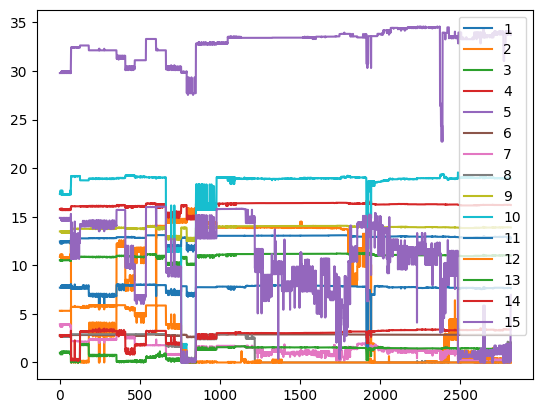

In [ ]:
stage1.plot()

In [ ]:
# X1 train데이터로 예측한 y1 측정값을 학습데이터로 만들어준다.
X2_train = pd.DataFrame(data = X2_train_scaled, columns = [['data1','data2','data3','data4','data5','data6','data7','data8']])

In [ ]:
X2_train['y1_1'] = pd.DataFrame(data = model_1.predict(train_feature_important_1))
X2_train['y1_2'] = pd.DataFrame(data = model_2.predict(train_feature_important_2))
X2_train['y1_3'] = pd.DataFrame(data = model_3.predict(train_feature_important_3))
X2_train['y1_4'] = pd.DataFrame(data = model_4.predict(train_feature_important_4))
X2_train['y1_5'] = pd.DataFrame(data = model_5.predict(train_feature_important_5))
X2_train['y1_6'] = pd.DataFrame(data = model_6.predict(train_feature_important_6))
X2_train['y1_7'] = pd.DataFrame(data = model_7.predict(train_feature_important_7))
X2_train['y1_8'] = pd.DataFrame(data = model_8.predict(train_feature_important_8))
X2_train['y1_9'] = pd.DataFrame(data = model_9.predict(train_feature_important_9))
X2_train['y1_10'] = pd.DataFrame(data = model_10.predict(train_feature_important_10))
X2_train['y1_11'] = pd.DataFrame(data = model_11.predict(train_feature_important_11))
X2_train['y1_12'] = pd.DataFrame(data = model_12.predict(train_feature_important_12))
X2_train['y1_13'] = pd.DataFrame(data = model_13.predict(train_feature_important_13))
X2_train['y1_14'] = pd.DataFrame(data = model_14.predict(train_feature_important_14))
X2_train['y1_15'] = pd.DataFrame(data = model_15.predict(train_feature_important_15))

In [ ]:
X2_train

,data1,data2,data3,data4,data5,data6,data7,data8
0,0.636364,0.636364,0.000000,0.333333,0.016129,0.135135,1.000000,0.040422
1,0.727273,0.727273,0.000000,0.166667,0.016129,0.135135,1.000000,0.032513
2,1.000000,1.000000,0.000000,0.166667,0.016129,0.135135,0.969697,0.035149
3,1.000000,1.000000,0.005525,0.166667,0.016129,0.135135,0.969697,0.035149
4,0.909091,0.909091,0.011050,0.166667,0.016129,0.135135,0.969697,0.027241
...,...,...,...,...,...,...,...,...
11265,0.363636,0.363636,0.889503,0.500000,1.000000,0.959459,0.272727,0.964851
11266,0.363636,0.363636,0.883978,0.333333,1.000000,0.959459,0.272727,0.966608
11267,0.454545,0.454545,0.883978,0.333333,1.000000,0.959459,0.272727,0.963972
11268,0.272727,0.272727,0.883978,0.333333,1.000000,0.959459,0.272727,0.963972


In [ ]:
#y2 예측을 위한 랜덤포레스트모델
yrf_reg_1 = RandomForestRegressor(n_estimators = 500, random_state=0)
yrf_reg_2 = RandomForestRegressor(n_estimators = 500, random_state=0)
yrf_reg_3 = RandomForestRegressor(n_estimators = 500, random_state=0)
yrf_reg_4 = RandomForestRegressor(n_estimators = 500, random_state=0)
yrf_reg_5 = RandomForestRegressor(n_estimators = 500, random_state=0)
yrf_reg_6 = RandomForestRegressor(n_estimators = 500,  random_state=0)
yrf_reg_7 = RandomForestRegressor(n_estimators = 500, random_state=0)
yrf_reg_8 = RandomForestRegressor(n_estimators = 500, random_state=0)
yrf_reg_9 = RandomForestRegressor(n_estimators = 500, random_state=0)
yrf_reg_10 = RandomForestRegressor(n_estimators = 500, random_state=0)
yrf_reg_11 = RandomForestRegressor(n_estimators = 500, random_state=0)
yrf_reg_12 = RandomForestRegressor(n_estimators = 500, random_state=0)
yrf_reg_13 = RandomForestRegressor(n_estimators = 500, random_state=0)
yrf_reg_14 = RandomForestRegressor(n_estimators = 500, random_state=0)
yrf_reg_15 = RandomForestRegressor(n_estimators = 500,  random_state=0)

In [ ]:
ymodel_1 = rf_reg_1.fit(X2_train, y2_1train_scaled[:,0])
ymodel_2 = rf_reg_2.fit(X2_train, y2_2train_scaled[:,0])
ymodel_3 = rf_reg_3.fit(X2_train, y2_3train_scaled[:,0])
ymodel_4 = rf_reg_4.fit(X2_train, y2_4train_scaled[:,0])
ymodel_5 = rf_reg_5.fit(X2_train, y2_5train_scaled[:,0])
ymodel_6 = rf_reg_6.fit(X2_train, y2_6train_scaled[:,0])
ymodel_7 = rf_reg_7.fit(X2_train, y2_7train_scaled[:,0])
ymodel_8 = rf_reg_8.fit(X2_train, y2_8train_scaled[:,0])
ymodel_9 = rf_reg_9.fit(X2_train, y2_9train_scaled[:,0])
ymodel_10 = rf_reg_10.fit(X2_train, y2_10train_scaled[:,0])
ymodel_11 = rf_reg_11.fit(X2_train, y2_11train_scaled[:,0])
ymodel_12 = rf_reg_12.fit(X2_train, y2_12train_scaled[:,0])
ymodel_13 = rf_reg_13.fit(X2_train, y2_13train_scaled[:,0])
ymodel_14 = rf_reg_14.fit(X2_train, y2_14train_scaled[:,0])
ymodel_15 = rf_reg_15.fit(X2_train, y2_15train_scaled[:,0])

In [ ]:
X2_test = pd.DataFrame(data = X2_test_scaled, columns = ['data1', 'data2', 'data3', 'data4', 'data5', 'data6', 'data7', 'data8'])

In [ ]:
X2_test['y1_1'] = pd.DataFrame(data = y1_1)
X2_test['y1_2'] = pd.DataFrame(data = y1_2)
X2_test['y1_3'] = pd.DataFrame(data = y1_3)
X2_test['y1_4'] = pd.DataFrame(data = y1_4)
X2_test['y1_5'] = pd.DataFrame(data = y1_5)
X2_test['y1_6'] = pd.DataFrame(data = y1_6)
X2_test['y1_7'] = pd.DataFrame(data = y1_7)
X2_test['y1_8'] = pd.DataFrame(data = y1_8)
X2_test['y1_9'] = pd.DataFrame(data = y1_9)
X2_test['y1_10'] = pd.DataFrame(data = y1_10)
X2_test['y1_11'] = pd.DataFrame(data = y1_11)
X2_test['y1_12'] = pd.DataFrame(data = y1_12)
X2_test['y1_13'] = pd.DataFrame(data = y1_13)
X2_test['y1_14'] = pd.DataFrame(data = y1_14)
X2_test['y1_15'] = pd.DataFrame(data = y1_15)

In [ ]:
X2_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2818 entries, 0 to 2817
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   data1   2818 non-null   float64
 1   data2   2818 non-null   float64
 2   data3   2818 non-null   float64
 3   data4   2818 non-null   float64
 4   data5   2818 non-null   float64
 5   data6   2818 non-null   float64
 6   data7   2818 non-null   float64
 7   data8   2818 non-null   float64
dtypes: float64(8)
memory usage: 176.2 KB


In [ ]:
X2_test_value = X2_test.values

In [ ]:
X2_test_value.shape

(2818, 8)

In [ ]:
#test 데이터셋으로 stage2의 예측값 계산
# MinMaxScaler decode해줘야함

y2_1 = ymodel_1.predict(X2_test_value)
y2_2 = ymodel_2.predict(X2_test_value)
y2_3 = ymodel_3.predict(X2_test_value)
y2_4 = ymodel_4.predict(X2_test_value)
y2_5 = ymodel_5.predict(X2_test_value)
y2_6 = ymodel_6.predict(X2_test_value)
y2_7 = ymodel_7.predict(X2_test_value)
y2_8 = ymodel_8.predict(X2_test_value)
y2_9 = ymodel_9.predict(X2_test_value)
y2_10 = ymodel_10.predict(X2_test_value)
y2_11 = ymodel_11.predict(X2_test_value)
y2_12 = ymodel_12.predict(X2_test_value)
y2_13 = ymodel_13.predict(X2_test_value)
y2_14 = ymodel_14.predict(X2_test_value)
y2_15 = ymodel_15.predict(X2_test_value)

In [ ]:
#MinMaxScaler inverse transform으로 예측값을 만들어준다.

real_y2_1 = y2_1scaler.inverse_transform(y2_1.reshape(-1,1))
real_y2_2 = y2_2scaler.inverse_transform(y2_2.reshape(-1,1))
real_y2_3 = y2_3scaler.inverse_transform(y2_3.reshape(-1,1))
real_y2_4 = y2_4scaler.inverse_transform(y2_4.reshape(-1,1))
real_y2_5 = y2_5scaler.inverse_transform(y2_5.reshape(-1,1))
real_y2_6 = y2_6scaler.inverse_transform(y2_6.reshape(-1,1))
real_y2_7 = y2_7scaler.inverse_transform(y2_7.reshape(-1,1))
real_y2_8 = y2_8scaler.inverse_transform(y2_8.reshape(-1,1))
real_y2_9 = y2_9scaler.inverse_transform(y2_9.reshape(-1,1))
real_y2_10 = y2_10scaler.inverse_transform(y2_10.reshape(-1,1))
real_y2_11 = y2_11scaler.inverse_transform(y2_11.reshape(-1,1))
real_y2_12 = y2_12scaler.inverse_transform(y2_12.reshape(-1,1))
real_y2_13 = y2_13scaler.inverse_transform(y2_13.reshape(-1,1))
real_y2_14 = y2_14scaler.inverse_transform(y2_14.reshape(-1,1))
real_y2_15 = y2_15scaler.inverse_transform(y2_15.reshape(-1,1))

In [ ]:
# 데이터프레임으로 확인
stage2 = pd.DataFrame()

stage2['1'] = pd.DataFrame(real_y2_1)
stage2['2'] = pd.DataFrame(real_y2_2)
stage2['3'] = pd.DataFrame(real_y2_3)
stage2['4'] = pd.DataFrame(real_y2_4)
stage2['5'] = pd.DataFrame(real_y2_5)
stage2['6'] = pd.DataFrame(real_y2_6)
stage2['7'] = pd.DataFrame(real_y2_7)
stage2['8'] = pd.DataFrame(real_y2_8)
stage2['9'] = pd.DataFrame(real_y2_9)
stage2['10'] = pd.DataFrame(real_y2_10)
stage2['11'] = pd.DataFrame(real_y2_11)
stage2['12'] = pd.DataFrame(real_y2_12)
stage2['13'] = pd.DataFrame(real_y2_13)
stage2['14'] = pd.DataFrame(real_y2_14)
stage2['15'] = pd.DataFrame(real_y2_15)

<AxesSubplot: >

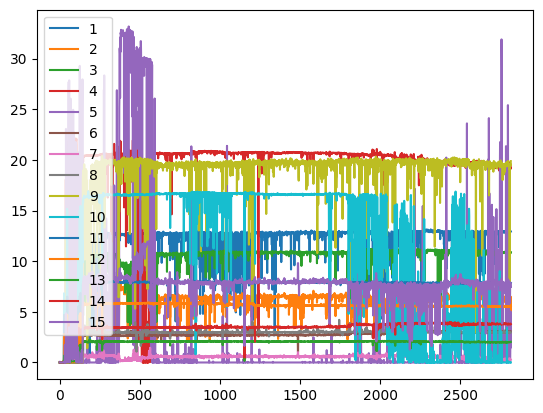

In [ ]:
stage2.plot()

## 딥러닝 회귀모델을 사용한 모델

In [ ]:
# MinMaxScaler적용을 위해 2차원으로 데이터를 변형 시켜준다
X1_train_ = X1_train.values.reshape(-1,len(X1_train.columns))
X2_train_ = X2_train.values.reshape(-1,len(X2_train.columns))
X1_test_ = X1_test.values.reshape(-1,len(X1_test.columns))
X2_test_ = X2_test.values.reshape(-1,len(X2_test.columns))

y1_train_ = y1_train.values.reshape(-1,len(y1_train.columns))
y2_train_ = y2_train.values.reshape(-1,len(y2_train.columns))
y1_test_ = y1_test.values.reshape(-1,len(y1_test.columns))
y2_test_ = y2_test.values.reshape(-1,len(y2_test.columns))

In [ ]:
#Scaler 정의
from sklearn.preprocessing import MinMaxScaler

X1scaler = MinMaxScaler()
X2scaler = MinMaxScaler()

y1scaler = MinMaxScaler()
y2scaler = MinMaxScaler()

In [ ]:
#데이터 정규화

X1scaler.fit(X1_train_)
X2scaler.fit(X2_train_)
y1scaler.fit(y1_train_)
y2scaler.fit(y2_train_)

X1_train_scaled = X1scaler.transform(X1_train_)
X2_train_scaled = X2scaler.transform(X2_train_)

y1_train_scaled = y1scaler.transform(y1_train_)
y2_train_scaled = y2scaler.transform(y2_train_)

X1_test_scaled = X1scaler.transform(X1_test_)
X2_test_scaled = X2scaler.transform(X2_test_)

y1_test_scaled = y1scaler.transform(y1_test_)
y2_test_scaled = y2scaler.transform(y2_test_)

In [ ]:
X1_train_scaled_df = pd.DataFrame(data = X1_train_scaled, columns = X1_train.columns)
X2_train_scaled_df = pd.DataFrame(data = X2_train_scaled, columns = X2_train.columns)
X1_test_scaled_df = pd.DataFrame(data = X1_test_scaled, columns = X1_test.columns)
X2_test_scaled_df = pd.DataFrame(data = X2_test_scaled, columns = X2_test.columns)

y1_train_scaled_df = pd.DataFrame(data = y1_train_scaled, columns = y1_train.columns)
y2_train_scaled_df = pd.DataFrame(data = y2_train_scaled, columns = y2_train.columns)
y1_test_scaled_df = pd.DataFrame(data = y1_test_scaled, columns = y1_test.columns)
y2_test_scaled_df = pd.DataFrame(data = y2_test_scaled, columns = y2_test.columns)

In [ ]:
from sklearn.feature_selection import VarianceThreshold

X1_thresholder = VarianceThreshold(threshold=0.08)
X1_thresholder.fit(X1_train_scaled)

X1_train_scaled = X1_thresholder.transform(X1_train_scaled)
X1_test_scaled = X1_thresholder.transform(X1_test_scaled)

In [ ]:
from sklearn.feature_selection import VarianceThreshold

X2_thresholder = VarianceThreshold(threshold=0.007)
X2_thresholder.fit(X2_train_scaled)

X2_train_scaled = X2_thresholder.transform(X2_train_scaled)
X2_test_scaled = X2_thresholder.transform(X2_test_scaled)

In [ ]:
X1_train_scaled_df = X1_train_scaled_df[X1_train_scaled_df.columns[X1_thresholder.get_support(indices=True)]]
X1_test_scaled_df = X1_test_scaled_df[X1_test_scaled_df.columns[X1_thresholder.get_support(indices=True)]]
X2_train_scaled_df = X2_train_scaled_df[X2_train_scaled_df.columns[X2_thresholder.get_support(indices=True)]]
X2_test_scaled_df = X2_test_scaled_df[X2_test_scaled_df.columns[X2_thresholder.get_support(indices=True)]]

In [ ]:
#시계열 정보를 넣어줌
X1_train_scaled_df.index = X1_train.index
X1_test_scaled_df.index = X1_test.index
X2_train_scaled_df.index = X2_train.index
X2_test_scaled_df.index = X2_test.index
y1_train_scaled_df.index = y1_train.index
y1_test_scaled_df.index = y1_test.index
y1_train_scaled_df.index = y1_train.index
y1_test_scaled_df.index = y1_test.index

In [ ]:
from keras.models import Sequential
from keras.layers import Dense

reg_model1 = Sequential()
reg_model1.add(Dense(120, activation="relu", input_shape=[X1_train_scaled_df.shape[1],]))
reg_model1.add(Dense(60, activation="relu"))
reg_model1.add(Dense(30, activation="relu"))
reg_model1.add(Dense(15))

reg_model1.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
from keras.callbacks import EarlyStopping 
early_stopping = EarlyStopping(monitor = 'loss', min_delta = 0, patience = 100, mode = 'auto')

history1 = reg_model1.fit(X1_train_scaled, y1_train_scaled, epochs=1000, callbacks = [early_stopping])

Epoch 1/1000
353/353 [==============================] - 1s 1ms/step - loss: 0.0383
Epoch 2/1000
353/353 [==============================] - 0s 962us/step - loss: 0.0177
Epoch 3/1000
353/353 [==============================] - 0s 935us/step - loss: 0.0173
Epoch 4/1000
353/353 [==============================] - 0s 937us/step - loss: 0.0171
Epoch 5/1000
353/353 [==============================] - 0s 955us/step - loss: 0.0171
Epoch 6/1000
353/353 [==============================] - 0s 926us/step - loss: 0.0168
Epoch 7/1000
353/353 [==============================] - 0s 937us/step - loss: 0.0166
Epoch 8/1000
353/353 [==============================] - 0s 958us/step - loss: 0.0163
Epoch 9/1000
353/353 [==============================] - 0s 944us/step - loss: 0.0161
Epoch 10/1000
353/353 [==============================] - 0s 952us/step - loss: 0.0157
Epoch 11/1000
353/353 [==============================] - 0s 947us/step - loss: 0.0152
Epoch 12/1000
353/353 [==============================] - 0s 913us

In [ ]:
y1= reg_model1.predict(X1_test_scaled)

89/89 [==============================] - 0s 1ms/step


- 예측한 y1 데이터를 X2에 추가를 해보자

In [ ]:
y1_train = reg_model1.predict(X1_train_scaled)

353/353 [==============================] - 0s 831us/step


In [ ]:
y1_train_df = pd.DataFrame()
y1_train_df = pd.DataFrame(data = y1_train, columns = ['y1_1','y1_2','y1_3','y1_4','y1_5','y1_6','y1_7','y1_8','y1_9','y1_10','y1_11','y1_12','y1_13','y1_14','y1_15'])

In [ ]:
y1_train_df.index = X1_train_scaled_df.index

In [ ]:
X2_train_scaled_df_new = pd.concat([X2_train_scaled_df, y1_train_df], axis=1)

In [ ]:
X2_test_scaled_df_new

,Machine4.Pressure.C.Actual,Machine4.Temperature4.C.Actual,Machine4.ExitTemperature.U.Actual,Machine5.Temperature2.C.Actual,Machine5.Temperature3.C.Actual,Machine5.Temperature4.C.Actual,Machine5.Temperature6.C.Actual,Machine5.ExitTemperature.U.Actual,y1_1,y1_2,y1_3,y1_4,y1_5,y1_6,y1_7,y1_8,y1_9,y1_10,y1_11,y1_12,y1_13,y1_14,y1_15
Date,,,,,,,,,,,,,,,,,,,,,,,
2019-03-06 10:52:34,0.818182,0.818182,0.000000,0.333333,0.016129,0.135135,1.000000,0.038664,0.605044,0.556236,0.636248,0.807720,0.899325,0.100458,0.603486,0.607030,0.900405,0.884486,0.592520,0.686200,0.316883,0.531578,0.781817
2019-03-06 10:52:35,0.727273,0.727273,0.000000,0.333333,0.016129,0.135135,1.000000,0.032513,0.608544,0.650340,0.638175,0.828777,0.900626,0.099670,0.621429,0.624192,0.928578,0.899012,0.623350,0.716205,0.274848,0.504295,0.789495
2019-03-06 10:52:36,0.818182,0.818182,0.000000,0.333333,0.016129,0.135135,1.000000,0.036907,0.605044,0.556236,0.636248,0.807720,0.899325,0.100458,0.603486,0.607030,0.900405,0.884486,0.592520,0.686200,0.316883,0.531578,0.781817
2019-03-06 10:52:37,0.909091,0.909091,0.000000,0.333333,0.016129,0.135135,1.000000,0.036028,0.611623,0.585229,0.640763,0.825834,0.908472,0.099809,0.610920,0.620119,0.922440,0.898072,0.608907,0.705683,0.315153,0.523632,0.787384
2019-03-06 10:52:39,0.727273,0.727273,0.000000,0.166667,0.016129,0.135135,1.000000,0.037786,0.607093,0.594298,0.635562,0.818555,0.900662,0.099449,0.613201,0.611084,0.925057,0.900386,0.605069,0.691160,0.310195,0.525933,0.782554
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-03-06 14:46:57,0.454545,0.454545,0.878453,0.500000,1.000000,0.959459,0.272727,0.968366,0.624452,0.152551,0.626267,0.810222,0.981243,0.100984,0.109610,0.145183,0.914137,0.923026,0.578962,-0.007520,0.363850,0.560339,0.237012
2019-03-06 14:47:09,0.363636,0.363636,0.883978,0.500000,1.000000,0.959459,0.272727,0.959578,0.622163,0.135497,0.623294,0.812070,0.980642,0.104151,0.146232,0.183880,0.939204,0.940840,0.575218,0.031060,0.377471,0.578175,0.311322
2019-03-06 14:47:14,0.454545,0.454545,0.889503,0.500000,1.000000,0.959459,0.272727,0.965729,0.617928,0.114489,0.617261,0.811297,0.965943,0.100304,0.170859,0.211557,0.957586,0.952263,0.570561,0.062910,0.383648,0.596105,0.359032


In [ ]:
X2_train_scaled_df_new

,Machine4.Pressure.C.Actual,Machine4.Temperature4.C.Actual,Machine4.ExitTemperature.U.Actual,Machine5.Temperature2.C.Actual,Machine5.Temperature3.C.Actual,Machine5.Temperature4.C.Actual,Machine5.Temperature6.C.Actual,Machine5.ExitTemperature.U.Actual,y1_1,y1_2,y1_3,y1_4,y1_5,y1_6,y1_7,y1_8,y1_9,y1_10,y1_11,y1_12,y1_13,y1_14,y1_15
Date,,,,,,,,,,,,,,,,,,,,,,,
2019-03-06 10:52:33,0.636364,0.636364,0.000000,0.333333,0.016129,0.135135,1.000000,0.040422,0.579786,0.519164,0.615703,0.748030,0.861546,0.100708,0.583930,0.578993,0.833625,0.842966,0.558600,0.664400,0.326115,0.525660,0.752081
2019-03-06 10:52:38,0.727273,0.727273,0.000000,0.166667,0.016129,0.135135,1.000000,0.032513,0.610799,0.592381,0.639640,0.826379,0.907209,0.099758,0.613201,0.626154,0.928254,0.901984,0.610876,0.712618,0.311979,0.522207,0.791797
2019-03-06 10:52:40,1.000000,1.000000,0.000000,0.166667,0.016129,0.135135,0.969697,0.035149,0.567716,0.500276,0.605186,0.712187,0.842149,0.099669,0.579199,0.558780,0.791249,0.820224,0.541238,0.647242,0.339551,0.523474,0.729437
2019-03-06 10:52:42,1.000000,1.000000,0.005525,0.166667,0.016129,0.135135,0.969697,0.035149,0.610691,0.601784,0.639058,0.825555,0.907049,0.099546,0.610313,0.626647,0.922789,0.897832,0.617277,0.722980,0.318109,0.514408,0.787326
2019-03-06 10:52:43,0.909091,0.909091,0.011050,0.166667,0.016129,0.135135,0.969697,0.027241,0.609986,0.604039,0.638582,0.826910,0.905587,0.099660,0.614990,0.628586,0.931657,0.903816,0.613898,0.716935,0.307264,0.518758,0.792821
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-03-06 14:47:13,0.363636,0.363636,0.889503,0.500000,1.000000,0.959459,0.272727,0.964851,0.619227,0.122349,0.619154,0.810432,0.972666,0.102759,0.164565,0.205074,0.951743,0.949354,0.571533,0.053674,0.382829,0.589888,0.346803
2019-03-06 14:47:16,0.363636,0.363636,0.883978,0.333333,1.000000,0.959459,0.272727,0.966608,0.611264,0.096224,0.623071,0.812152,0.901973,0.096423,0.167346,0.240007,0.970154,0.953425,0.578037,0.086974,0.382318,0.575443,0.311506
2019-03-06 14:47:17,0.454545,0.454545,0.883978,0.333333,1.000000,0.959459,0.272727,0.963972,0.612719,0.106224,0.627075,0.810944,0.903191,0.097770,0.154584,0.234818,0.961365,0.947995,0.581371,0.080270,0.379518,0.564630,0.279402


In [ ]:
from keras.models import Sequential
from keras.layers import Dense

reg_model2 = Sequential()
reg_model2.add(Dense(120, activation="relu", input_shape=[X2_train_scaled_df_new.shape[1],]))
reg_model2.add(Dense(60, activation="relu"))
reg_model2.add(Dense(30, activation="relu"))
reg_model2.add(Dense(15))

reg_model2.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
from keras.callbacks import EarlyStopping 
early_stopping = EarlyStopping(monitor = 'loss', min_delta = 0, patience = 100, mode = 'auto')

history2 = reg_model2.fit(X2_train_scaled_df_new, y2_train_scaled, epochs=1000, callbacks = [early_stopping])

Epoch 1/1000
353/353 [==============================] - 1s 1ms/step - loss: 0.0410
Epoch 2/1000
353/353 [==============================] - 0s 1ms/step - loss: 0.0140
Epoch 3/1000
353/353 [==============================] - 0s 1ms/step - loss: 0.0128
Epoch 4/1000
353/353 [==============================] - 0s 1ms/step - loss: 0.0121
Epoch 5/1000
353/353 [==============================] - 0s 1ms/step - loss: 0.0117
Epoch 6/1000
353/353 [==============================] - 0s 1ms/step - loss: 0.0113
Epoch 7/1000
353/353 [==============================] - 0s 1ms/step - loss: 0.0110
Epoch 8/1000
353/353 [==============================] - 0s 1ms/step - loss: 0.0108
Epoch 9/1000
353/353 [==============================] - 0s 1ms/step - loss: 0.0106
Epoch 10/1000
353/353 [==============================] - 0s 1ms/step - loss: 0.0103
Epoch 11/1000
353/353 [==============================] - 0s 1ms/step - loss: 0.0101
Epoch 12/1000
353/353 [==============================] - 0s 1ms/step - loss: 0.0099
E

In [ ]:
y2= reg_model2.predict(X2_test_scaled_df_new)

89/89 [==============================] - 0s 674us/step


In [ ]:
y1.shape, X1_test.shape

((2818, 15), (2818, 41))

In [ ]:
y1_real = y1scaler.inverse_transform(y1)

In [ ]:
y2_real = y2scaler.inverse_transform(y2)

In [ ]:
stage1_sub_pred = y1_real # stage1의 예측값
stage2_sub_pred = y2_real # stage2의 예측값

## 채점

결과로 제출할 파일을 저장 후, 아래 코드를 실행하면 채점을 수행합니다.

**아래 코드를 수정하면 정상적으로 채점이 이루어지지 않을 수 있습니다.**

### 주의: 코드 파일도 채점 코드로 전달하기 때문에 아래 코드를 실행하기 전에 반드시 저장 버튼 혹은 <kbd>Ctrl</kbd> + <kbd>S</kbd>를 눌러 변경사항을 모두 저장하시길 바랍니다.

In [ ]:
result_dict = {
    'stage1': stage1_sub_pred.tolist(), # stage1의 예측값
    'stage2': stage2_sub_pred.tolist(), # stage2의 예측값
}

In [ ]:
import json
import os

with open("result.json", "w") as f:
    json.dump(result_dict, f)

os.system("elice_grade result.json time_series_regression.ipynb")

send files ['result.json', 'time_series_regression.ipynb'] for grade...


Compressed 2355200 bytes into 1520641 bytes ==> 64.57%


waiting result...
done!

Score: 64.826373
Duration: 2.147477388381958 seconds
=== Message ===
제출 완료되었습니다.


0